In [1]:
import sys
sys.path.append('../code/')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from nilearn import datasets, plotting

from mamba_ssm import Mamba

import utils
from train_ann_sweep import get_generators
import pickle

device = torch.device("cuda:0")
# device = torch.device("cpu")

In [2]:
atlas = datasets.fetch_atlas_msdl()
# Loading atlas image stored in 'maps'
atlas_filename = atlas["maps"]
# Loading atlas data stored in 'labels'
labels = atlas["labels"]

df = pd.read_pickle('../data/developmental_df.pkl')
n_subjects = len(np.unique(df['subj'].values))

time_series = df.iloc[:,:-1].values

pca = PCA(n_components=39)
points = pca.fit_transform(time_series)

correlation_matrix = np.corrcoef(time_series.T)

In [3]:
with open('../data/ann_bottleneck_sweep_results.pkl', 'rb') as f:
    metadata = pickle.load(f)
print(metadata['bottleneck_values'])

[1, 3, 5, 7, 9, 11, 13, 15]


In [29]:
def get_ann_networks(fold=0, bottleneck=15): 
    with open('../data/ann_bottleneck_sweep_results.pkl', 'rb') as f:
        metadata = pickle.load(f)

    input_size = metadata[f'bottleneck_{bottleneck}'][f'fold_{fold}']['metadata']['input_size']
    encoder_layer_size = metadata[f'bottleneck_{bottleneck}'][f'fold_{fold}']['metadata']['encoder_layer_size']
    decoder_layer_size = metadata[f'bottleneck_{bottleneck}'][f'fold_{fold}']['metadata']['decoder_layer_size']


    model = utils.model_ann_autoencoder(input_size, encoder_layer_size, decoder_layer_size, bottleneck=bottleneck).to(device)
    state_dict = torch.load(f'../models/ann/bottleneck/ann_fold{fold}_bottleneck{bottleneck}.pt')
    model.load_state_dict(state_dict)

    n_regions = len(labels)
    coords = np.array(atlas.region_coords)

    functional_networks = list()
    coords_list = list()
    region_list = list()

    # std_threshold = 1.5
    std_threshold = 2

    for bottleneck_idx in range(bottleneck):
        bottleneck_input = torch.zeros((1, 100, bottleneck)).to(device)
        bottleneck_input[0,:,bottleneck_idx] = torch.linspace(-10, 10, 100)

        decoder_output = model.decoder(bottleneck_input).detach().cpu().numpy()

        decoder_std = np.std(decoder_output[0,:,:], axis=0)
        region_idx = np.where(decoder_std > std_threshold)[0]

        num_nodes = len(region_idx)
        temp_network = np.zeros((num_nodes, num_nodes))
        for i in range(num_nodes):
            for j in range(num_nodes):
                node1, node2 = region_idx[i], region_idx[j]
                temp_network[i, j] = correlation_matrix[node1, node2]
        
        functional_networks.append(temp_network)
        coords_list.append(coords[np.in1d(range(n_regions),region_idx), :])
        region_list.append(region_idx)
    

def get_mamba_networks(fold=0, bottleneck=15): 
    with open('../data/mamba_bottleneck_sweep_results.pkl', 'rb') as f:
        metadata = pickle.load(f)

    input_size = metadata[f'bottleneck_{bottleneck}'][f'fold_{fold}']['metadata']['input_size']
    encoder_hidden = metadata[f'bottleneck_{bottleneck}'][f'fold_{fold}']['metadata']['encoder_hidden']
    decoder_hidden = metadata[f'bottleneck_{bottleneck}'][f'fold_{fold}']['metadata']['decoder_hidden']


    model = utils.model_mamba_autoencoder(input_size, encoder_hidden, decoder_hidden, bottleneck=bottleneck).to(device)
    state_dict = torch.load(f'../models/mamba/bottleneck/mamba_fold{fold}_bottleneck{bottleneck}.pt')
    model.load_state_dict(state_dict)

    n_regions = len(labels)
    coords = np.array(atlas.region_coords)

    functional_networks = list()
    coords_list = list()
    region_list = list()

    # std_threshold = 1.5
    std_threshold = 2

    for bottleneck_idx in range(bottleneck):
        bottleneck_input = torch.zeros((1, 100, bottleneck)).to(device)
        bottleneck_input[0,:,bottleneck_idx] = torch.linspace(-10, 10, 100)

        out = model.decoder_ann(bottleneck_input)
        out = model.decoder_mamba(out)
        decoder_output = model.fc_out(out).detach().cpu().numpy()


        decoder_std = np.std(decoder_output[0,:,:], axis=0)
        region_idx = np.where(decoder_std > std_threshold)[0]

        num_nodes = len(region_idx)
        temp_network = np.zeros((num_nodes, num_nodes))
        for i in range(num_nodes):
            for j in range(num_nodes):
                node1, node2 = region_idx[i], region_idx[j]
                temp_network[i, j] = correlation_matrix[node1, node2]
        
        functional_networks.append(temp_network)
        coords_list.append(coords[np.in1d(range(n_regions),region_idx), :])
        region_list.append(region_idx)

    return functional_networks, coords_list, region_list


def get_pca_networks():
    loadings_threshold = 0.2

    explained_var = np.cumsum(pca.explained_variance_ratio_)
    explained_var = np.concatenate([[0], explained_var])
    thresh_pos = np.argmin(np.abs(explained_var - 0.8))

    n_regions = len(labels)
    coords = np.array(atlas.region_coords)
    functional_networks = list()
    coords_list = list()
    region_list = list()

    for pca_idx in range(thresh_pos):
        region_idx = np.where(np.abs(pca.components_[pca_idx,:]) > loadings_threshold)[0]
        num_nodes = len(region_idx)
        temp_network = np.zeros((num_nodes, num_nodes))
        for i in range(num_nodes):
            for j in range(num_nodes):
                node1, node2 = region_idx[i], region_idx[j]
                temp_network[i, j] = correlation_matrix[node1, node2]
        
        functional_networks.append(temp_network)
        coords_list.append(coords[np.in1d(range(n_regions),region_idx), :])
        region_list.append(region_idx)

    return functional_networks, coords_list, region_list



In [33]:
# ae_functional_networks, ae_coords_list, ae_region_list = get_autoencoder_networks(fold=0)
ae_functional_networks, ae_coords_list, ae_region_list = get_mamba_networks(fold=0)
ae_functional_networks, ae_coords_list, ae_region_list = get_mamba_networks(fold=1)

# pca_functional_networks, pca_coords_list, pca_region_list = get_pca_networks()
# pca_functional_networks, pca_coords_list, pca_region_list = get_autoencoder_networks(fold=0)

In [34]:
network_similarity = np.zeros((len(pca_region_list), len(ae_region_list)))
for pca_idx in range(len(pca_region_list)):
    for ae_idx in range(len(ae_region_list)):
        pca_regions, ae_regions = np.zeros(len(labels)), np.zeros(len(labels))
        pca_regions[pca_region_list[pca_idx]] = 1.0
        ae_regions[ae_region_list[ae_idx]] = 1.0

        overlap = np.sum((pca_regions + ae_regions) == 2.0) / np.max([len(ae_regions), len(pca_regions)])

        network_similarity[pca_idx, ae_idx] = overlap


Text(0.5, 1.0, 'AE vs PCA Functional Net Overlap')

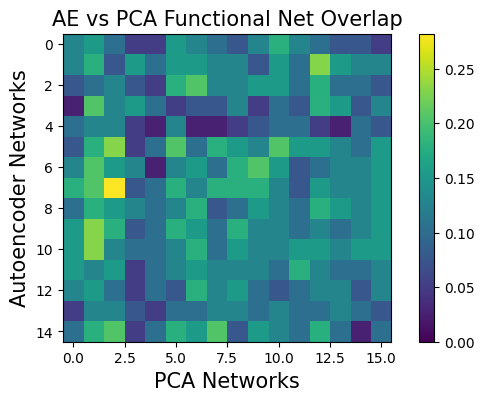

In [35]:
labelsize = 15
ticksize = 10
plt.figure(figsize=(7,4))
plt.imshow(network_similarity.T, vmin=0.0)
plt.xlabel('PCA Networks', fontsize=labelsize)
plt.ylabel('Autoencoder Networks', fontsize=labelsize)
plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)
plt.colorbar()

plt.title('AE vs PCA Functional Net Overlap', fontsize=labelsize)

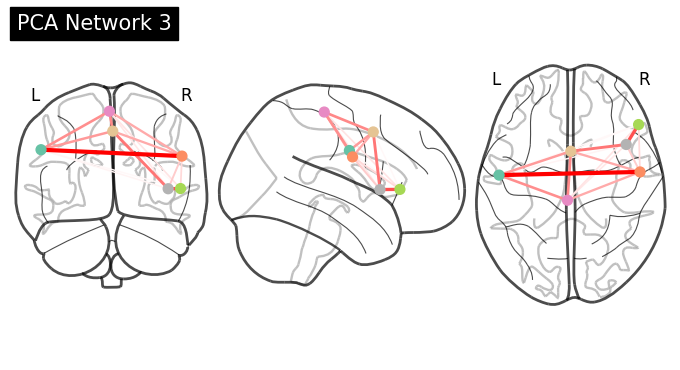

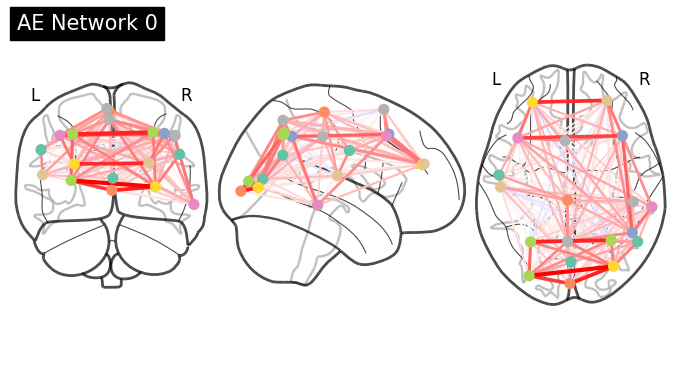

In [36]:
pca_net_idx = 3
ae_net_idx = 0

plotting.plot_connectome(pca_functional_networks[pca_net_idx], pca_coords_list[pca_net_idx], title=f'PCA Network {pca_net_idx}')
plotting.plot_connectome(ae_functional_networks[ae_net_idx], ae_coords_list[ae_net_idx], title=f'AE Network {ae_net_idx}')

In [116]:
pca_net_idx = 8
ae_net_idx = 5

plotting.plot_connectome(pca_functional_networks[pca_net_idx], pca_coords_list[pca_net_idx], title=f'PCA Network {pca_net_idx}')
plotting.plot_connectome(ae_functional_networks[ae_net_idx], ae_coords_list[ae_net_idx], title=f'AE Network {ae_net_idx}')

IndexError: list index out of range

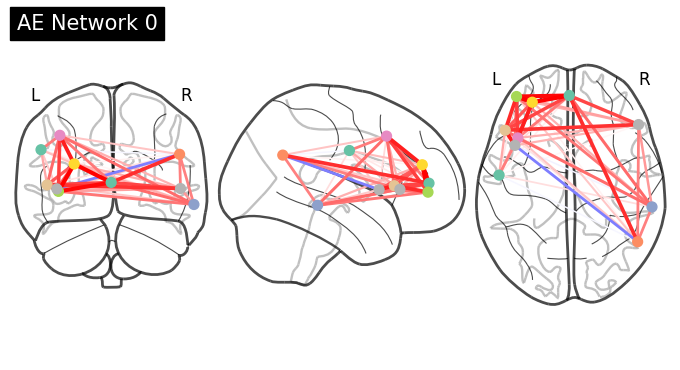

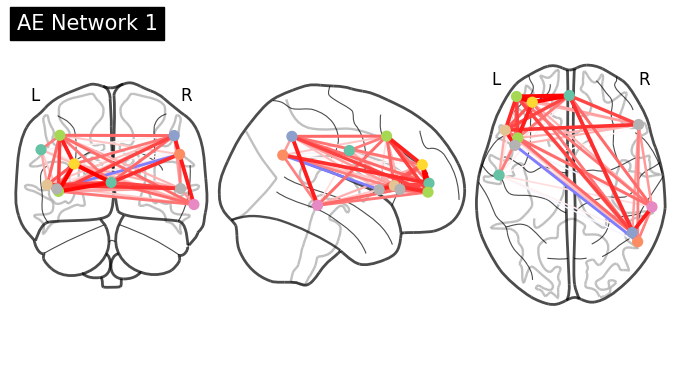

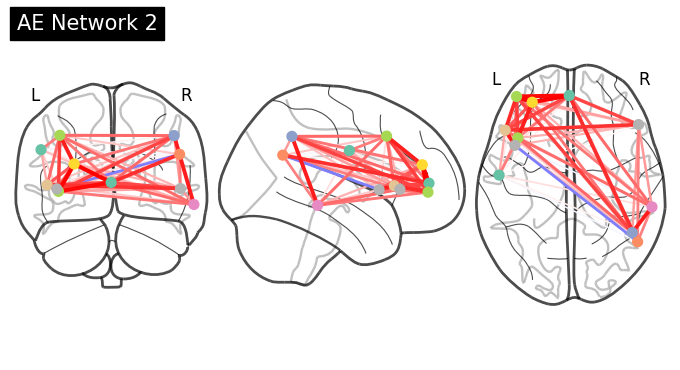

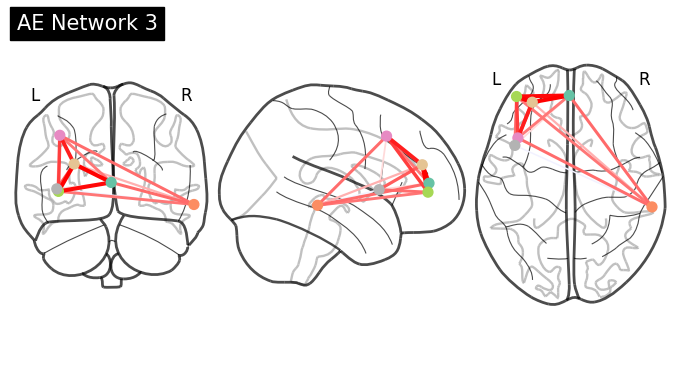

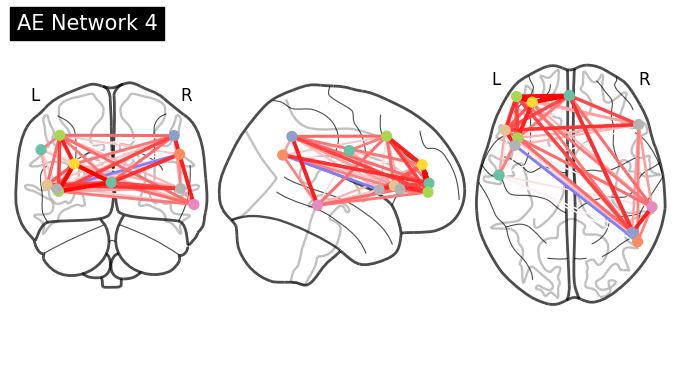

In [117]:
for net_idx in range(5):
    plotting.plot_connectome(ae_functional_networks[net_idx], ae_coords_list[net_idx], title=f'AE Network {net_idx}')
# plotting.show()

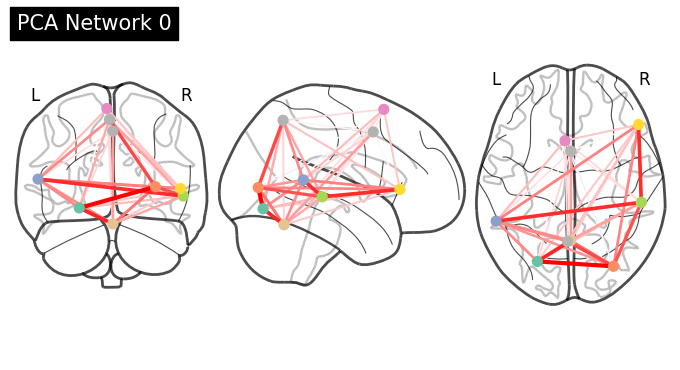

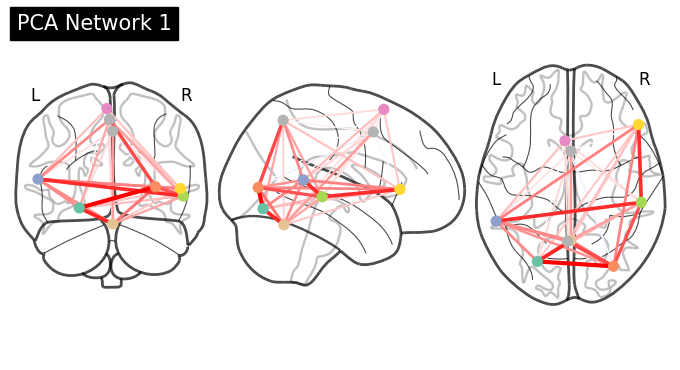

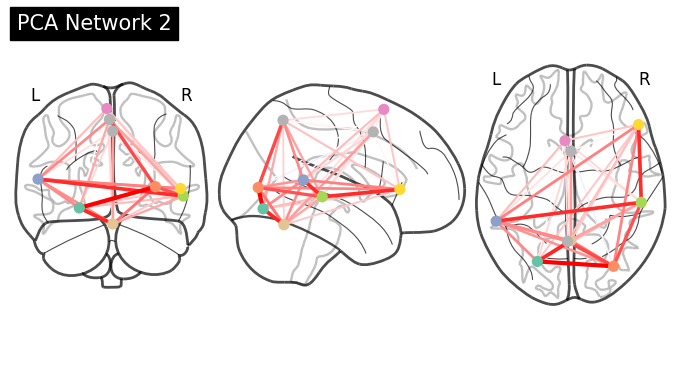

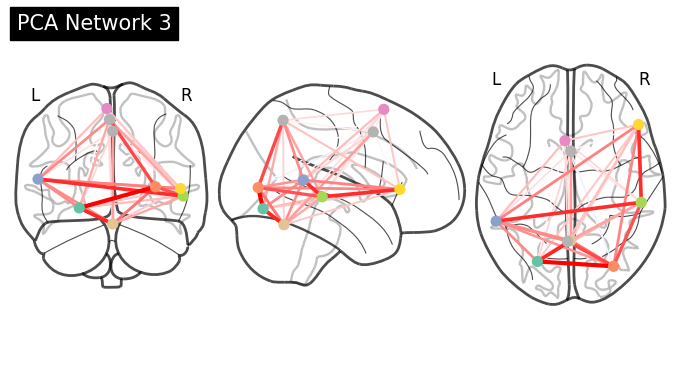

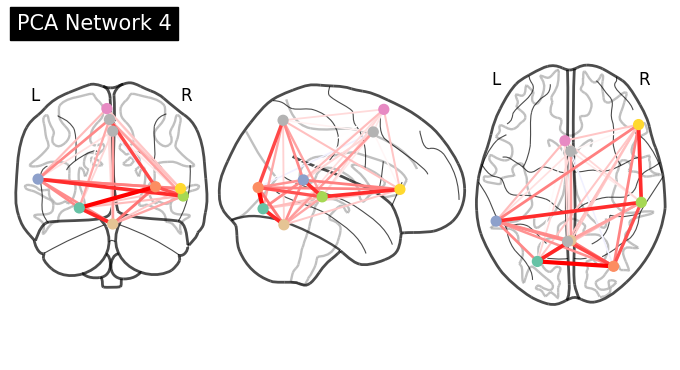

In [118]:
for net_idx in range(5):
    plotting.plot_connectome(pca_functional_networks[net_idx], pca_coords_list[net_idx], title=f'PCA Network {net_idx}')
# plotting.show()